<a href="https://colab.research.google.com/github/asierbilbao/IronLab/blob/main/Final%20project/Final%20project/MMM_marketplace_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install lightweight_mmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lightweight_mmm import preprocessing, lightweight_mmm, plot, optimize_media, utils

In [ ]:
import jax.numpy as jnp
import numpyro
numpyro.set_host_device_count(2)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Advertising_Analyst_Work_1.csv to Advertising_Analyst_Work_1 (1).csv


In [ ]:
import pandas as pd
import io
 
df = pd.read_csv(io.BytesIO(uploaded['Advertising_Analyst_Work_1.csv']))
df

,Unnamed: 0,Date,Brand Alias,Ad group alias,ASIN/SKU Alias,Marketplace,Impressions,Clicks,Spend,Sales,Orders,Units,Advertised Units sold,Other SKU units sold,Advertised SKU Sales,Other SKU sales
0,0,2021-10-17,Brand 1,Brand 1 Ad Group 10,ASIN414,Walmart,33,0,0.00,0.00,0,0,0,0,0.00,0.00
1,1,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN385,Walmart,0,0,0.00,0.00,0,0,0,0,0.00,0.00
2,2,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN389,Walmart,0,0,0.00,0.00,0,0,0,0,0.00,0.00
3,3,2021-10-17,Brand 1,Brand 1 Ad Group 13,ASIN377,Walmart,380,8,2.34,0.00,0,0,0,0,0.00,0.00
4,4,2021-10-17,Brand 1,Brand 1 Ad Group 13,ASIN399,Walmart,3805,7,6.68,0.00,0,0,0,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9581,9581,2022-01-11,Brand 2,Brand 2 Ad Group 2,ASIN508,Amazon,4639,10,7.36,0.00,0,0,0,0,0.00,0.00
9582,9582,2022-01-11,Brand 2,Brand 2 Ad Group 3,ASIN512,Amazon,15336,49,33.79,638.74,6,6,1,5,55.99,455.00
9583,9583,2022-01-11,Brand 2,Brand 2 Ad Group 3,ASIN516,Amazon,4811,6,3.66,0.00,0,0,0,0,0.00,0.00
9584,9584,2022-01-11,Brand 2,Brand 2 Ad Group 3,ASIN520,Amazon,22838,36,19.57,294.95,4,4,3,1,158.97,76.99


We need to create the followig datasets:
- Media data (clicks)
- Costs data (spend)
- Revenue data (sales)

In [ ]:
df_total = df.groupby(["Date", "Ad group alias"])[["Impressions","Spend", "Sales",]].sum()
df_total = df_total.drop(["Brand 1 Ad Group 12"], axis=0, level=1)

media_data_base = df_total['Impressions'].unstack().fillna(0)
costs_base = df_total['Spend'].unstack().fillna(0)
sales_base = df_total['Sales'].reset_index().groupby("Date").sum()

print(media_data_base.shape)
print(costs_base.shape)
print(sales_base.shape)

(87, 19)
(87, 19)
(87, 1)


In [ ]:
import pandas as pd

# we will split the data in this ("2021-12-14") 

# Media data (impressions) - train and test
media_data_train = media_data_base.loc[:'2021-12-14']
media_data_test = media_data_base.loc['2021-12-15':]

# Target data (revenue) - train and test
target_train = sales_base.loc[:'2021-12-14']
target_test = sales_base.loc['2021-12-15':]

# Cost data (amount spent in each brand/adgroup)
costs_train = costs_base.loc[:'2021-12-14'].sum(axis=0).loc[media_data_train.columns]
costs_test = costs_base.loc['2021-12-15':].sum(axis=0).loc[media_data_test.columns]

In [ ]:
import numpy as np
# Create extra features (organic data)
organic_raw = pd.DataFrame({'organic_search': 0, 'organic_social': 0}, index=media_data_base.index)
organic_raw['organic_search'] = sales_base.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])
organic_raw['organic_social'] = sales_base.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])


<ipython-input-9-d16782c3322a>:4: DeprecationWarning: This function is deprecated. Please call randint(10000, 100000 + 1) instead
  organic_raw['organic_search'] = sales_base.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])
<ipython-input-9-d16782c3322a>:5: DeprecationWarning: This function is deprecated. Please call randint(10000, 100000 + 1) instead
  organic_raw['organic_social'] = sales_base.values/10 + np.random.random_integers(10000, 100000, organic_raw.shape[0])


In [ ]:
# Split organic data in train and test
organic_data_train = organic_raw.loc[:'2021-12-14']
organic_data_test = organic_raw.loc['2021-12-15':]

Scaling The Data

In [ ]:
import jax.numpy as jnp

# Create the scalers! 
# In a Bayesia model especially is very important the scaling part because the model is very data sensitive. e.g. we have 1000 organic visits.

media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

In [ ]:
# Scale the data

# media data TRAIN
media_data_train_scaled = media_scaler.fit_transform(media_data_train.values)
# TEST
media_data_test_scaled = media_scaler.transform(media_data_test.values)

# extra features: organic TRAIN
organic_data_train_scaled = organic_scaler.fit_transform(organic_data_train.values)
# TEST
organic_data_test_scaled = organic_scaler.transform(organic_data_test.values)
#all
organic_data_scaled = organic_scaler.transform(organic_raw.values)


# target data TRAIN
target_train_scaled = target_scaler.fit_transform(target_train.values.squeeze())
target_train_scaled_Experiment = target_scaler.fit_transform(target_train.values) # Experiment (withou Squeeze)
# target data !TEST!


# cost data TRAIN
costs_train_scaled = cost_scaler.fit_transform(costs_train.values)
# TEST
costs_test_scaled = cost_scaler.fit_transform(costs_test.values)

In [ ]:
target_train_scaled.shape

(59,)

Finding The Right Hyper-Parameters

In [ ]:
mmm = lightweight_mmm.LightweightMMM(model_name="adstock")

In [ ]:
mmm.fit(
            media=media_data_train_scaled,
            media_prior=costs_train_scaled,
            target=target_train_scaled,
            extra_features=organic_data_train_scaled,
            number_warmup=1000,
            number_samples=1000,
            number_chains=1,
            degrees_seasonality=1,
            weekday_seasonality=True,
            seasonality_frequency=365,
            seed=1)
    

sample: 100%|██████████| 2000/2000 [02:09<00:00, 15.40it/s, 1023 steps of size 2.73e-03. acc. prob=0.92]


In [ ]:
# Good Rhat
mmm.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
coef_extra_features[0]      1.90      0.94      1.90      0.27      3.33    436.73      1.00
coef_extra_features[1]      1.07      0.82      1.08     -0.17      2.47    457.27      1.00
         coef_media[0]      0.08      0.06      0.07      0.00      0.15    407.05      1.00
         coef_media[1]      0.00      0.00      0.00      0.00      0.00    531.35      1.00
         coef_media[2]      0.29      0.45      0.10      0.00      0.86    680.91      1.00
         coef_media[3]      0.12      0.11      0.09      0.00      0.26    657.97      1.00
         coef_media[4]      0.22      0.28      0.09      0.00      0.63    308.76      1.00
         coef_media[5]      0.03      0.02      0.02      0.00      0.05    468.21      1.00
         coef_media[6]      0.59      1.12      0.09      0.00      1.88    322.54      1.00
         coef_media[7]      0.01      0.01      0.01      0.00      0

In [ ]:
# The version we need to plot the charts

!pip uninstall -y matplotlib
!pip install matplotlib==3.3.4

Found existing installation: matplotlib 3.3.4
Uninstalling matplotlib-3.3.4:
  Successfully uninstalled matplotlib-3.3.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.3.4-cp38-cp38-manylinux1_x86_64.whl (11.6 MB)


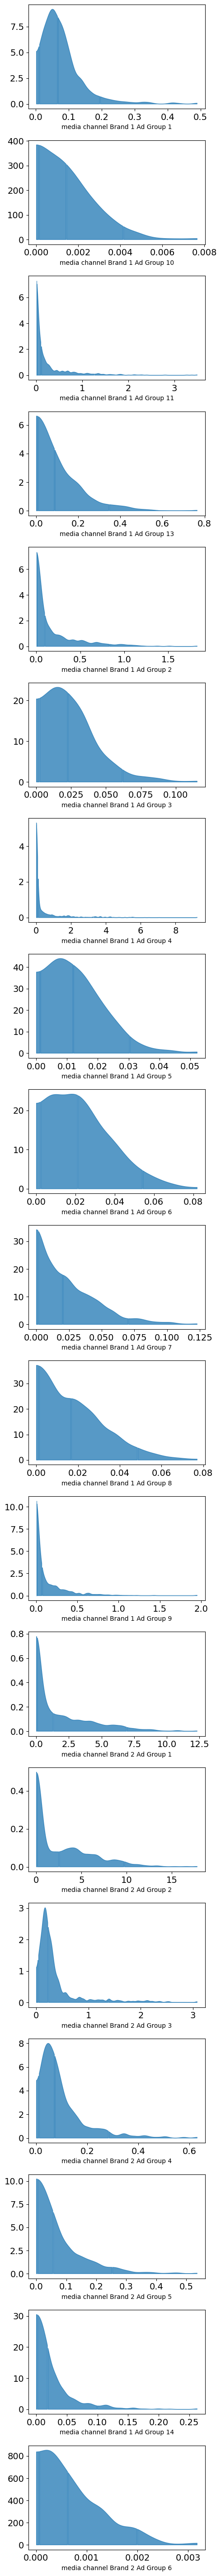

In [ ]:
# Media effect

media_names = media_data_base.columns

plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names)

In [ ]:
# scale the test media data to make predictions on unseen data

new_predictions = mmm.predict(
    media=media_data_test_scaled,
    extra_features=organic_data_test_scaled,
    target_scaler=target_scaler)

p = new_predictions.mean(axis=0)

new_predictions.shape

(1000, 28)

In [ ]:
new_predictions = mmm.predict(
    media=media_data_test_scaled,
    extra_features=organic_data_test_scaled)

new_predictions.shape

(1000, 28)

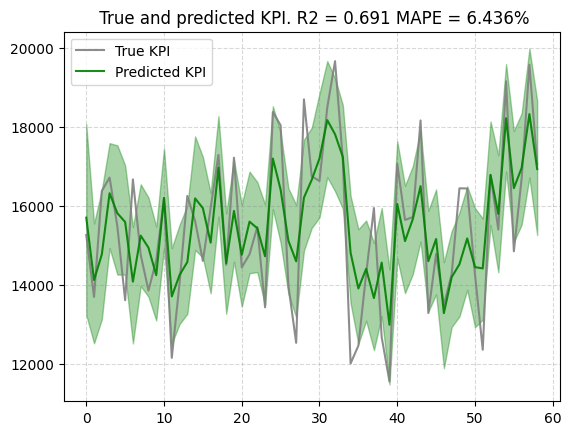

In [ ]:
# check the model predicts training data
# passing the scaler gives unscaled results

plot.plot_model_fit(mmm, target_scaler=target_scaler)

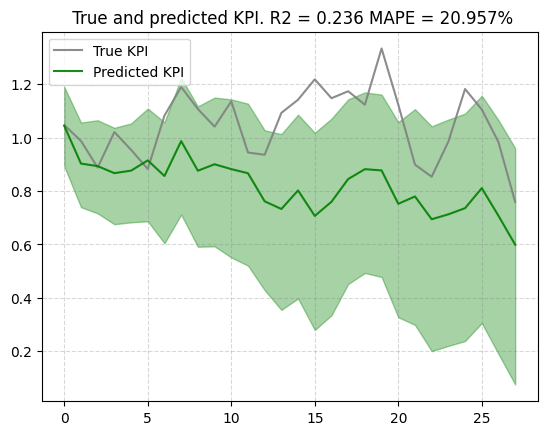

In [ ]:
# scale the test media data to make predictions on unseen data

# target Test (important to put squeeze, otherwise it doesn't match)
target_test_scaled = target_scaler.transform(target_test.values.squeeze())

plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_test_scaled)

In [ ]:
# estimate media effects with their respective credibility intervals
media_effect, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

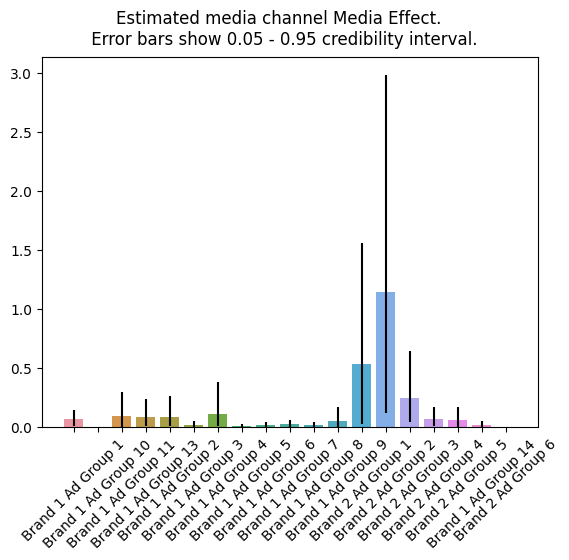

In [ ]:
# plot media effects
plot.plot_bars_media_metrics(metric=media_effect, metric_name="Media Effect", channel_names=media_names)

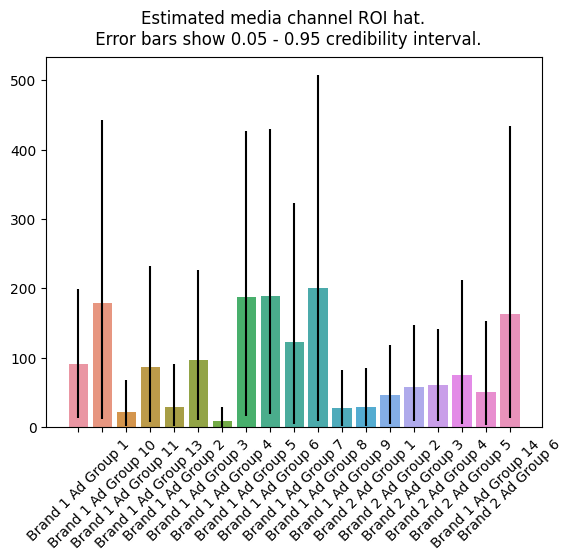

In [ ]:
# plot media roi
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=media_names)

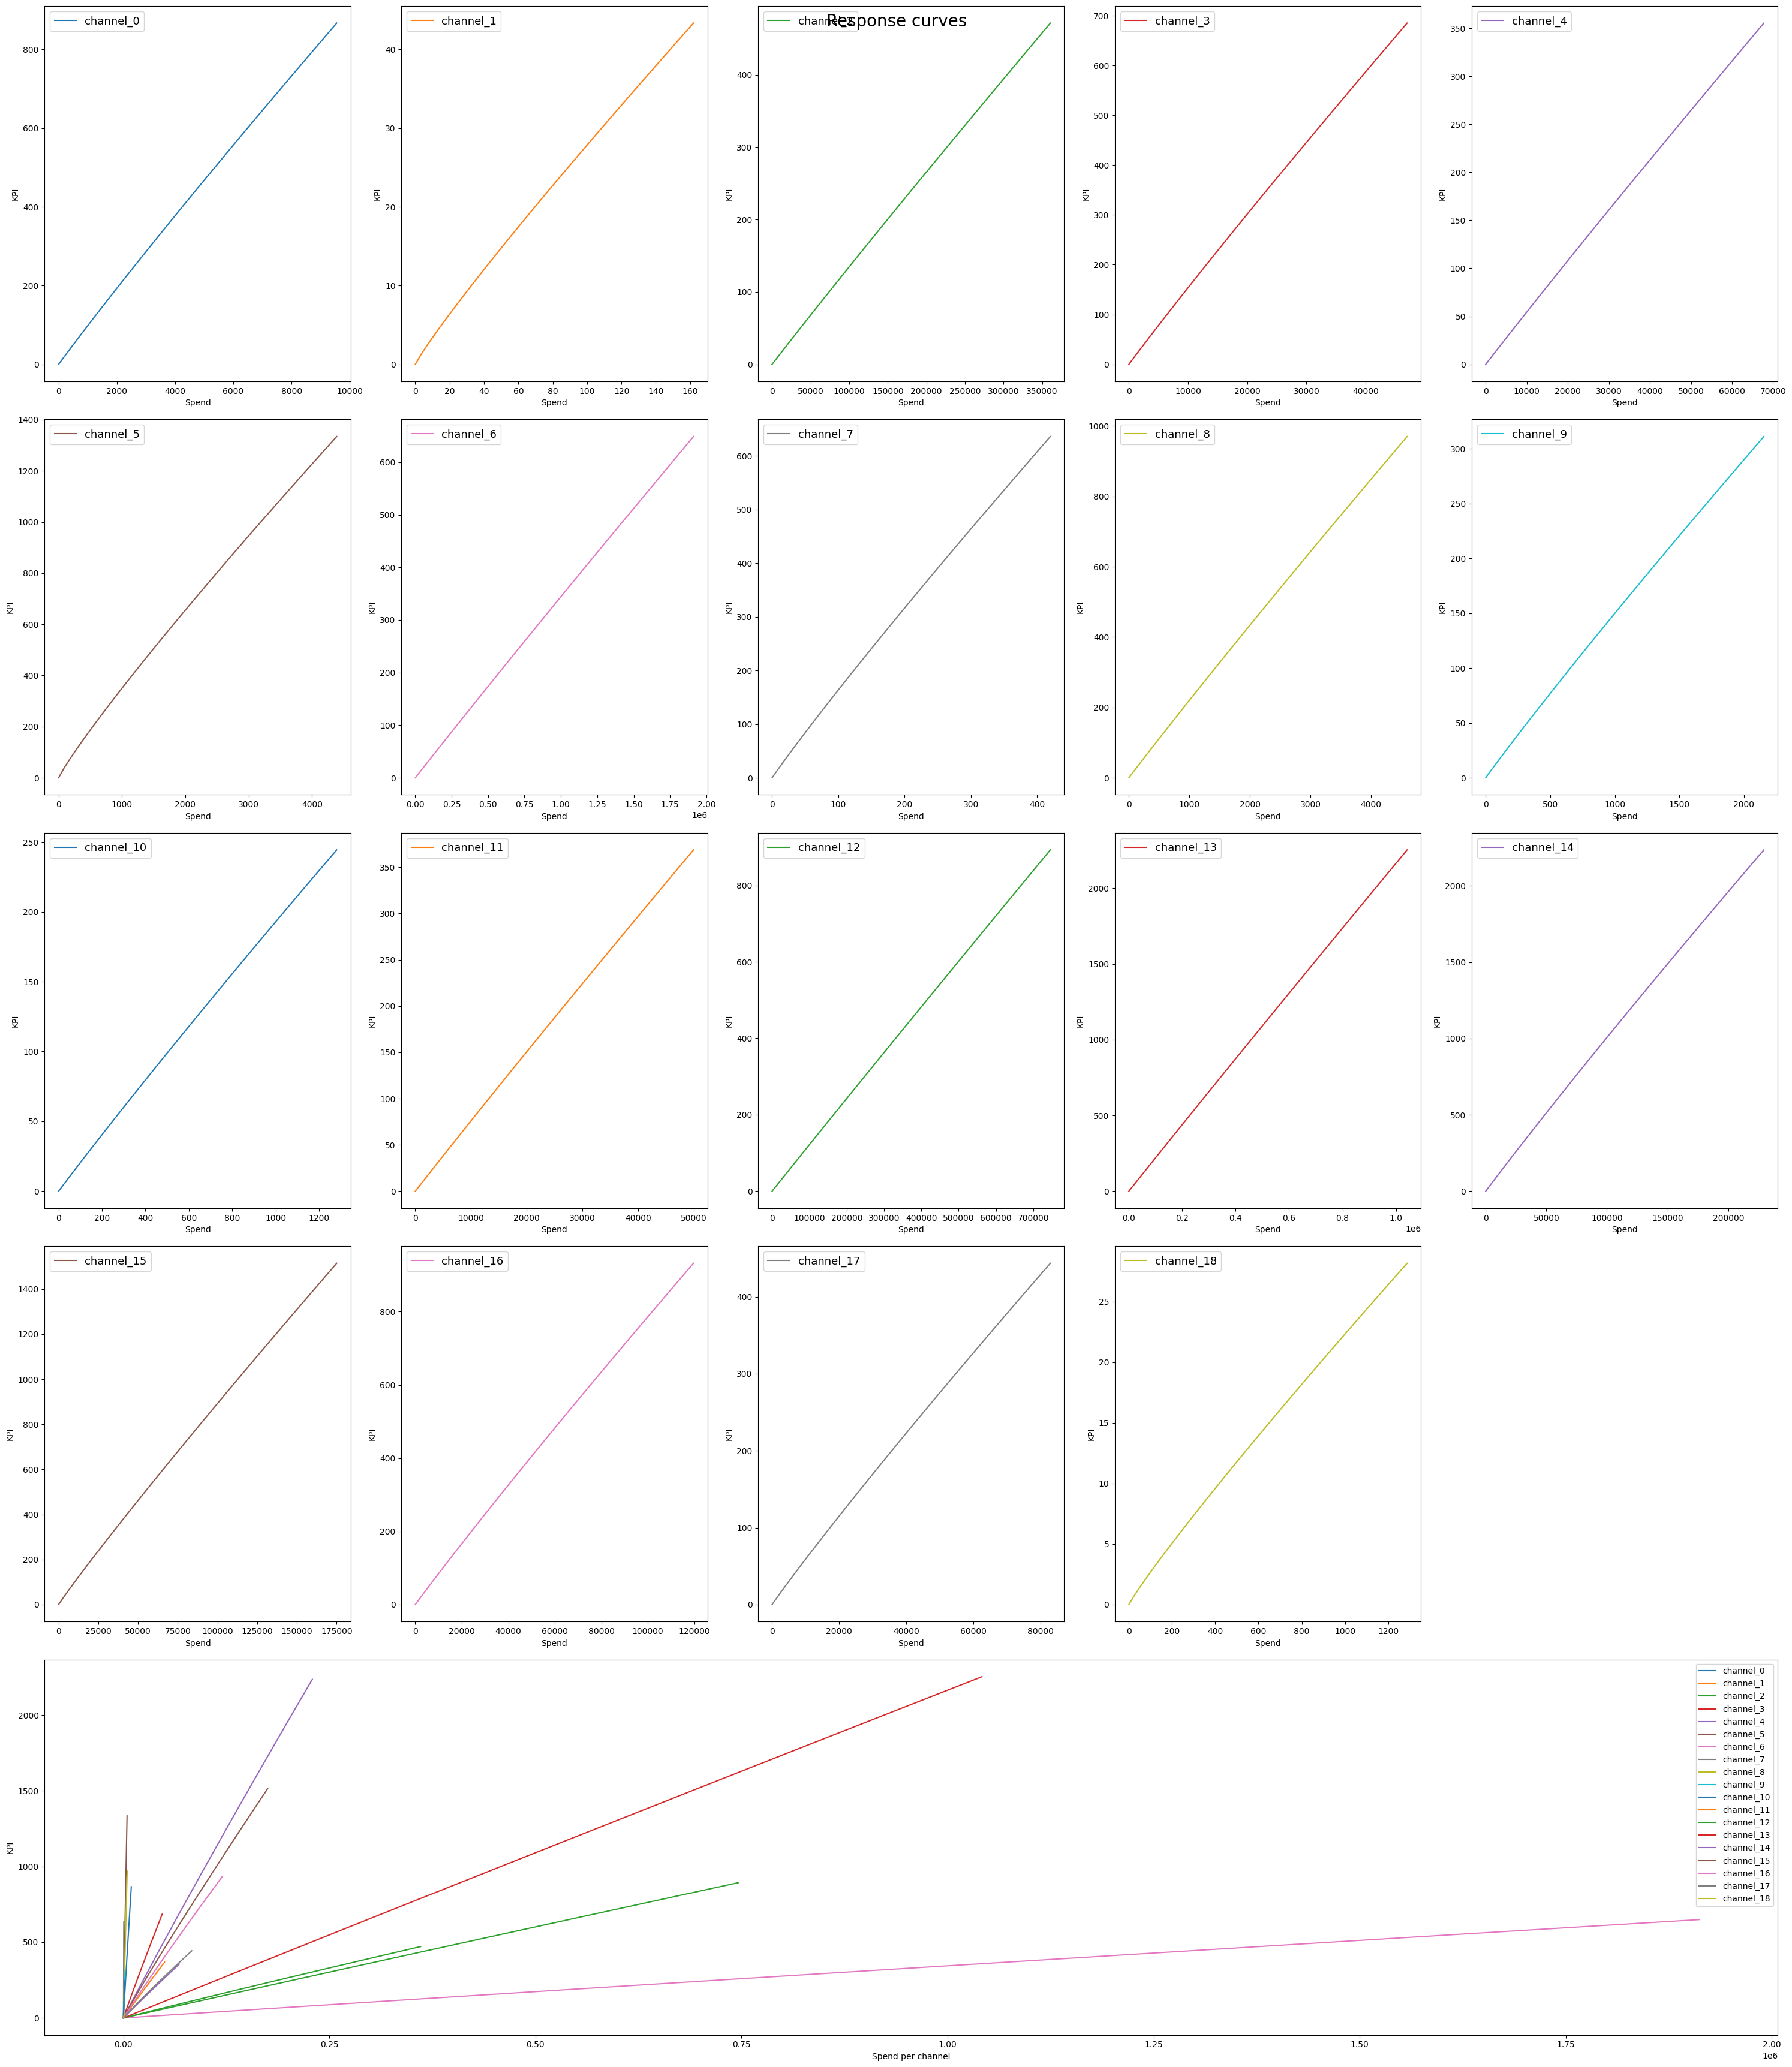

In [ ]:
# plot response curves for channels
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, media_scaler=media_scaler, figure_size= (30, 35), n_columns= 5, marker_size= 8, legend_fontsize= 13)

In [ ]:
# if you used impressions for media variables, this should be an array of average CPMs
# if you used spend then just put an array of 1s like we did here

costs = costs_base.sum(axis=0).loc[media_names]
prices_CPM = (costs / media_data_base.sum(axis=0))*1000

# fix the NaN values
prices_CPM = prices_CPM.fillna(0)

prices_CPM

Ad group alias
Brand 1 Ad Group 1      6.571536
Brand 1 Ad Group 10    10.629195
Brand 1 Ad Group 11     1.910698
Brand 1 Ad Group 13     1.708510
Brand 1 Ad Group 2      3.679952
Brand 1 Ad Group 3     23.349858
Brand 1 Ad Group 4      1.015212
Brand 1 Ad Group 5     46.783947
Brand 1 Ad Group 6      8.347649
Brand 1 Ad Group 7      9.064548
Brand 1 Ad Group 8      6.105114
Brand 1 Ad Group 9      6.984761
Brand 2 Ad Group 1      1.748862
Brand 2 Ad Group 2      1.541379
Brand 2 Ad Group 3      1.428285
Brand 2 Ad Group 4      1.500231
Brand 2 Ad Group 5      1.453848
Brand 1 Ad Group 14     1.299895
Brand 2 Ad Group 6      0.766522
dtype: float64

In [ ]:
print(prices_CPM.shape)
print(extra_features_forecast.shape)
print(organic_data_test_scaled[:30].shape)
print(media_scaler)

(19,)
(28, 2)
(28, 2)


In [ ]:
pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# float64 is not supported by JAX library, we could change to float32
# However, it didn't work because AX is a numerical computing library for the Python programming language, and it provides support for a range of data types, including float32, but not when the data is stored in a Pandas Series.


# Convert the data from a Pandas Series to a NumPy array
media_data_base = media_data_base.to_numpy()

AttributeError: ignored

In [ ]:
prices_CPM

Ad group alias
Brand 1 Ad Group 1      6.571536
Brand 1 Ad Group 10    10.629195
Brand 1 Ad Group 11     1.910698
Brand 1 Ad Group 13     1.708510
Brand 1 Ad Group 2      3.679952
Brand 1 Ad Group 3     23.349858
Brand 1 Ad Group 4      1.015212
Brand 1 Ad Group 5     46.783947
Brand 1 Ad Group 6      8.347649
Brand 1 Ad Group 7      9.064548
Brand 1 Ad Group 8      6.105114
Brand 1 Ad Group 9      6.984761
Brand 2 Ad Group 1      1.748862
Brand 2 Ad Group 2      1.541379
Brand 2 Ad Group 3      1.428285
Brand 2 Ad Group 4      1.500231
Brand 2 Ad Group 5      1.453848
Brand 1 Ad Group 14     1.299895
Brand 2 Ad Group 6      0.766522
dtype: float64

In [ ]:
n_time_periods = 30
budget = sum(costs)/media_data_base.shape[0]
organic_data_forecast = organic_data_test_scaled[:n_time_periods]


In [ ]:
budget

2496.2012643678167

In [ ]:
print(prices_CPM.shape)
print(organic_data_forecast.shape)
print(budget)

(19,)
(28, 2)
2496.2012643678167


In [ ]:
# run budget optimization
solution = optimize_media.find_optimal_budgets( 
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=organic_data_scaled[-30:, :],
    budget=budget,
    prices=prices_CPM.values,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    bounds_lower_pct= 1.1,
    bounds_upper_pct= 1.1,)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 391287.0030061219
            Iterations: 111
            Function evaluations: 5070
            Gradient evaluations: 107


In [ ]:
solution_x = solution[0].x

In [ ]:
solution

(     fun: DeviceArray(488604.80903804, dtype=float64)
      jac: array([-6.66362539e-01, -1.13994295e+00, -1.88221085e-01, -1.57026683e-01,
        -5.87344105e-02, -4.42880436e+00, -4.67694470e-03, -5.69498891e+00,
        -1.34628878e+00, -2.57729562e+00, -7.06962820e-01, -1.05414766e-01,
        -3.30191940e-01, -2.61124664e-02, -2.83970548e-01, -3.87429183e-01,
        -9.33725773e-02, -6.47783031e-02, -9.40148790e-02])
  message: 'Optimization terminated successfully'
     nfev: 1274
      nit: 31
     njev: 31
   status: 0
  success: True
        x: array([8.10221287e+00, 5.77125375e+00, 1.52727909e-21, 3.23387014e+01,
        1.70909441e+00, 2.21512902e-01, 2.27098261e+02, 2.33137717e+01,
        4.72743707e-01, 2.76746709e-02, 8.91341939e+01, 3.78572923e-01,
        0.00000000e+00, 2.53369942e+02, 3.16266959e-01, 8.08830603e-05,
        9.16667552e+00, 1.44769774e+01, 2.54205601e+01]),
 DeviceArray(488800.57808412, dtype=float64),
 DeviceArray([3.63854421e+00, 2.62071802e-02, 

In [ ]:
for x in range(len(solution_x)):
    share = round(solution_x[x] / jnp.sum(solution_x)*100, 2)
    print(media_names[x], ": ", share, "%")

Brand 1 Ad Group 1 :  1.17 %
Brand 1 Ad Group 10 :  0.83 %
Brand 1 Ad Group 11 :  0.0 %
Brand 1 Ad Group 13 :  4.68 %
Brand 1 Ad Group 2 :  0.25 %
Brand 1 Ad Group 3 :  0.03 %
Brand 1 Ad Group 4 :  32.85 %
Brand 1 Ad Group 5 :  3.37 %
Brand 1 Ad Group 6 :  0.07 %
Brand 1 Ad Group 7 :  0.0 %
Brand 1 Ad Group 8 :  12.889999 %
Brand 1 Ad Group 9 :  0.049999997 %
Brand 2 Ad Group 1 :  0.0 %
Brand 2 Ad Group 2 :  36.649998 %
Brand 2 Ad Group 3 :  0.049999997 %
Brand 2 Ad Group 4 :  0.0 %
Brand 2 Ad Group 5 :  1.3299999 %
Brand 1 Ad Group 14 :  2.09 %
Brand 2 Ad Group 6 :  3.6799998 %


Retraining LightweightMMM